# Modelling Rental Price

In this notebook we incorporate all the rental property and external datasets for each region to produce models for weekly rental price for properties across Victoria.

We also find how each feature influences the prices of the properties.

### Importing Libraries and Functions

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

### Reading in the Datasets

In [27]:
greater_melbourne = pd.read_csv("../data/curated/final_datasets/greater_melbourne_train.csv")
rest_of_vic = pd.read_csv("../data/curated/final_datasets/rest_of_vic_train.csv")

In [28]:
greater_melbourne.head()

,beds,baths,parking,dist_to_city,dist_to_education,dist_to_parks_and_gardens,dist_to_train_station,dist_to_healthcare,weekly_cost,num_homeless_persons,...,median_income,median_age,percent_aboriginal_torres_strait_islander,percent_au_citizen,percent_overseas_born,percent_rental_properties,population,percent_unemployed,housing_index,cpi_without_housing
0,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,680.0,34.666667,...,69755.0,42.46,0.313333,4.393333,35.14,43.72,14208.250639,4.573333,145.288421,127.830132
1,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,775.0,34.666667,...,69755.0,42.46,0.313333,4.393333,35.14,43.72,14208.250639,4.573333,145.288421,127.830132
2,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,775.0,34.666667,...,69358.0,42.12,0.303333,4.673333,34.76,43.58,13106.132992,4.543333,141.520263,125.573860
3,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,680.0,34.666667,...,68564.0,41.44,0.283333,5.233333,34.00,43.30,12696.762148,4.483333,133.983947,121.061316
4,2.0,1.0,1.0,4.42985,0.52632,0.19365,3.36613,0.44046,675.0,34.666667,...,68564.0,41.44,0.283333,5.233333,34.00,43.30,12696.762148,4.483333,133.983947,121.061316


### Pre-modelling Analysis

1. Weekly Cost

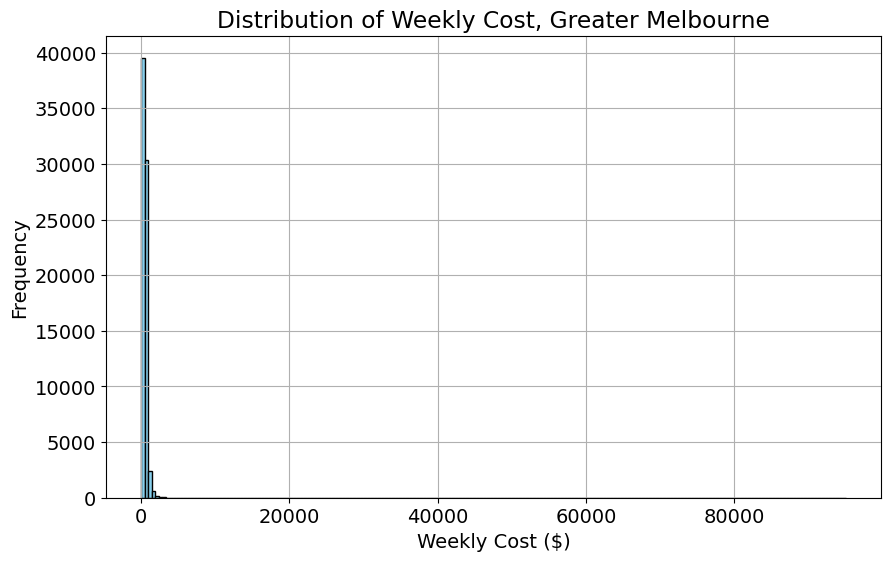

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(greater_melbourne['weekly_cost'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Cost, Greater Melbourne')
plt.xlabel('Weekly Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

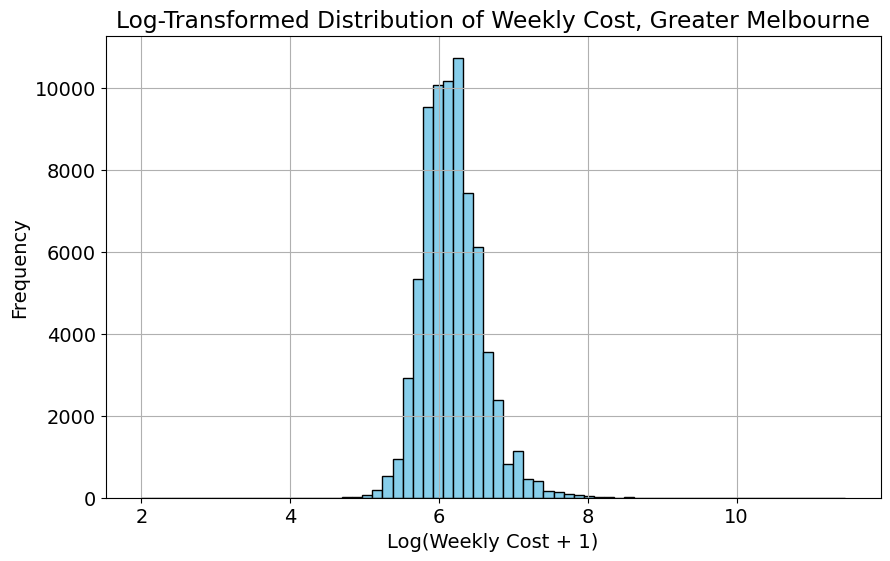

In [30]:
# Log transformation of the 'weekly_cost' column
log_weekly_cost = np.log1p(greater_melbourne['weekly_cost'])

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(log_weekly_cost, bins=70, color='skyblue', edgecolor='black')
plt.title('Log-Transformed Distribution of Weekly Cost, Greater Melbourne')
plt.xlabel('Log(Weekly Cost + 1)')
plt.ylabel('Frequency')
plt.grid(True)

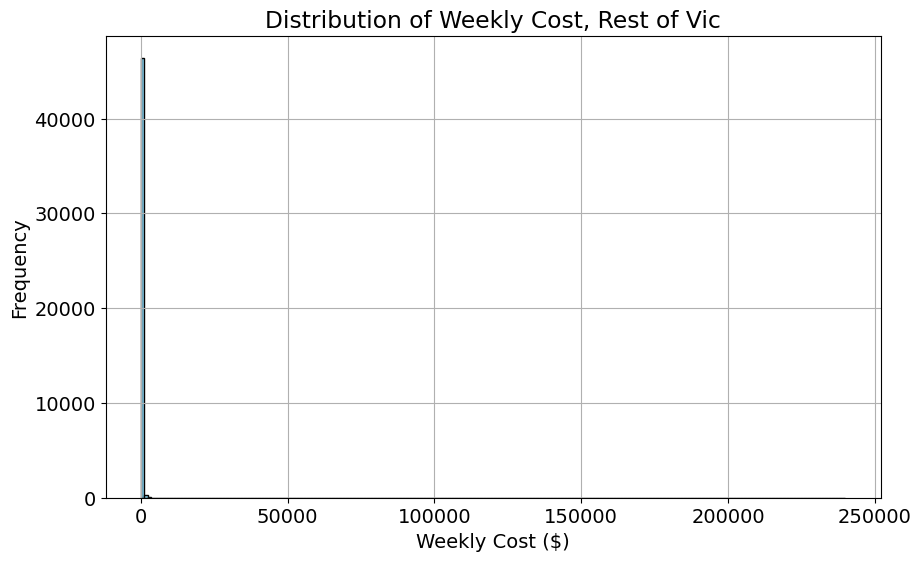

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(rest_of_vic['weekly_cost'], bins=200, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Cost, Rest of Vic')
plt.xlabel('Weekly Cost ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

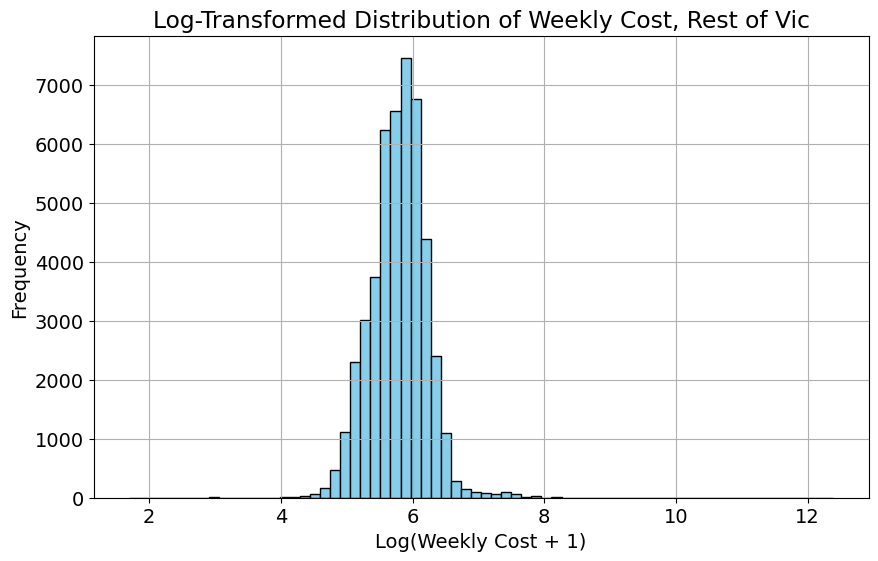

In [32]:
# Log transformation of the 'weekly_cost' column
log_weekly_cost = np.log1p(rest_of_vic['weekly_cost'])

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
plt.hist(log_weekly_cost, bins=70, color='skyblue', edgecolor='black')
plt.title('Log-Transformed Distribution of Weekly Cost, Rest of Vic')
plt.xlabel('Log(Weekly Cost + 1)')
plt.ylabel('Frequency')
plt.grid(True)

## Training the Models

### 1. Greater Melbourne Models

Here we decide to remove the top 2.5% of properties based on rental price to combat any potential outliers in the data

In [33]:
# Finding the bottom 97.5% of data
threshold = greater_melbourne['weekly_cost'].quantile(0.975)

# Filtering out the top 2.5%, retaining the bottom 97.5% of properties
greater_melbourne = greater_melbourne[greater_melbourne['weekly_cost'] <= threshold]

##### **1. Regular Linear Regression:**

Linear Regression MSE (log-transformed scale): 0.0402566845012015
Linear Regression MSE (original scale): 11865.490660705831
Linear Regression RMSE (original scale): 108.9288330090148


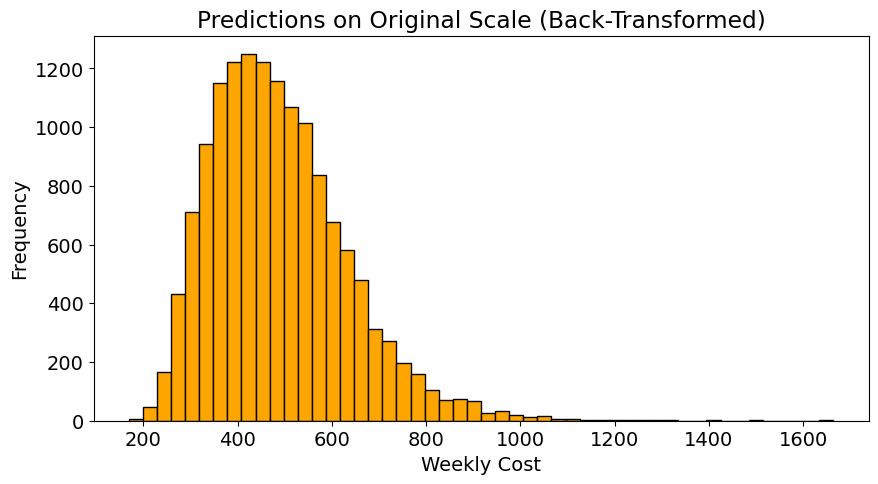


Feature Importances (Coefficients):
Feature: beds, Coefficient: 0.1580
Feature: baths, Coefficient: 0.0803
Feature: parking, Coefficient: 0.0185
Feature: dist_to_city, Coefficient: -0.0429
Feature: dist_to_education, Coefficient: 0.0058
Feature: dist_to_parks_and_gardens, Coefficient: 0.0060
Feature: dist_to_train_station, Coefficient: -0.0094
Feature: dist_to_healthcare, Coefficient: 0.0089
Feature: num_homeless_persons, Coefficient: -0.0112
Feature: avg_household_size, Coefficient: -0.0359
Feature: num_businesses, Coefficient: 0.0238
Feature: median_income, Coefficient: 0.0285
Feature: median_age, Coefficient: 0.0572
Feature: percent_aboriginal_torres_strait_islander, Coefficient: -0.0549
Feature: percent_au_citizen, Coefficient: 0.0133
Feature: percent_overseas_born, Coefficient: -0.0105
Feature: percent_rental_properties, Coefficient: 0.0871
Feature: population, Coefficient: 0.1093
Feature: percent_unemployed, Coefficient: -0.0478
Feature: housing_index, Coefficient: 336238267547.

In [34]:
# Step 1: Drop NaN values
greater_melbourne = greater_melbourne.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_gm = greater_melbourne.drop(columns=['weekly_cost'])
y_gm_log = np.log1p(greater_melbourne['weekly_cost'])  # log1p for better handling of small values

# Step 3: Scale the features
scaler = StandardScaler()
X_gm_scaled = scaler.fit_transform(X_gm)

# Step 4: Split the dataset into training and testing sets
X_train_gm, X_test_gm, y_train_gm, y_test_gm = train_test_split(X_gm_scaled, y_gm_log, test_size=0.2, random_state=42)

# Step 5: Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_gm, y_train_gm)

# Step 6: Make predictions on the test set (log-transformed)
y_pred_lr_gm = lr_model.predict(X_test_gm)

# Step 7: Evaluate the model on the log-transformed data (MSE in log scale)
mse_log = mean_squared_error(y_test_gm, y_pred_lr_gm)
print('Linear Regression MSE (log-transformed scale):', mse_log)

# Step 8: Back-transform the predictions and true values to the original scale
y_pred_lr_gm_orig = np.expm1(y_pred_lr_gm)  # Convert predictions back to the original scale
y_test_gm_orig = np.expm1(y_test_gm)        # Convert true values back to the original scale

# Step 9: Calculate MSE and RMSE on the original scale
mse_original = mean_squared_error(y_test_gm_orig, y_pred_lr_gm_orig)
rmse_original = np.sqrt(mse_original)
print('Linear Regression MSE (original scale):', mse_original)
print('Linear Regression RMSE (original scale):', rmse_original)

# Step 11: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_lr_gm_orig, bins=50, color='orange', edgecolor='black')
plt.title('Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 12: Coefficients with feature names
importance_lr = lr_model.coef_
feature_names = X_gm.columns

print("\nFeature Importances (Coefficients):")
for feature, importance in zip(feature_names, importance_lr):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


##### **2. LASSO Regression:**

Here we test LASSO as opposed to the normal regression but we find this gave the same result

In [35]:
# Perform Lasso with cross-validation to automatically select the best alpha (penalty)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_gm, y_train_gm)

# Select non-zero coefficient features
lasso_selected_features = X_gm.columns[lasso.coef_ != 0]
print("Selected features by Lasso:", lasso_selected_features)

# Evaluate Lasso model
y_pred_lasso = lasso.predict(X_test_gm)

y_pred_lasso_orig = np.expm1(y_pred_lasso)  # Convert Lasso predictions back to original scale
y_test_gm_orig = np.expm1(y_test_gm)        # Convert true values back to original scale

# Step 5: Calculate MSE and RMSE on the original scale
mse_lasso_original = mean_squared_error(y_test_gm_orig, y_pred_lasso_orig)
rmse_lasso_original = np.sqrt(mse_lasso_original)

# Output the MSE and RMSE for the Lasso model on the original scale
print('Lasso Regression MSE (original scale):', mse_lasso_original)
print('Lasso Regression RMSE (original scale):', rmse_lasso_original)

Selected features by Lasso: Index(['beds', 'baths', 'parking', 'dist_to_city', 'dist_to_education',
       'dist_to_parks_and_gardens', 'dist_to_train_station',
       'dist_to_healthcare', 'num_homeless_persons', 'avg_household_size',
       'num_businesses', 'median_income', 'median_age',
       'percent_aboriginal_torres_strait_islander', 'percent_au_citizen',
       'percent_overseas_born', 'percent_rental_properties', 'population',
       'percent_unemployed', 'housing_index'],
      dtype='object')
Lasso Regression MSE (original scale): 11871.58623141531
Lasso Regression RMSE (original scale): 108.95680901813942


##### *(back to using the Regular Linear Regression Model)*

- Applying **Feature Elimination**

In [36]:
# Step 1: Perform Recursive Feature Elimination (RFE)
lr_model_rfe = LinearRegression()
rfe = RFE(lr_model_rfe, n_features_to_select=10)  # Adjust number of features to select
rfe.fit(X_train_gm, y_train_gm)

# Step 2: Selected features
selected_features = X_gm.columns[rfe.support_]
print("Selected features by RFE:", selected_features)

# Step 3: Fit the model using selected features
X_train_selected = rfe.transform(X_train_gm)
X_test_selected = rfe.transform(X_test_gm)
lr_model_rfe.fit(X_train_selected, y_train_gm)

# Step 4: Predictions and evaluation on log-transformed scale
y_pred_rfe = lr_model_rfe.predict(X_test_selected)

# Step 5: Back-transform the predictions and true values to the original scale
y_pred_rfe_orig = np.expm1(y_pred_rfe)  # Convert predictions back to original scale
y_test_gm_orig = np.expm1(y_test_gm)    # Convert true values back to original scale

# Step 6: Calculate MSE and RMSE on the original scale
mse_rfe_original = mean_squared_error(y_test_gm_orig, y_pred_rfe_orig)
rmse_rfe_original = np.sqrt(mse_rfe_original)

# Output the MSE and RMSE on the original scale
print('Linear Regression MSE after RFE (original scale):', mse_rfe_original)
print('Linear Regression RMSE after RFE (original scale):', rmse_rfe_original)


Selected features by RFE: Index(['beds', 'baths', 'median_income', 'median_age',
       'percent_aboriginal_torres_strait_islander',
       'percent_rental_properties', 'population', 'percent_unemployed',
       'housing_index', 'cpi_without_housing'],
      dtype='object')
Linear Regression MSE after RFE (original scale): 12277.804386499785
Linear Regression RMSE after RFE (original scale): 110.8052543271292


- Adding **Interaction Terms** and **Feature Importance**

In [37]:
# Step 1: Add interaction terms (degree=2 for interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_gm)
X_test_poly = poly.transform(X_test_gm)

# Step 2: Train the linear regression model with interaction terms
lr_model_poly = LinearRegression()
lr_model_poly.fit(X_train_poly, y_train_gm)

# Step 3: Predictions and evaluation (log-transformed scale)
y_pred_poly = lr_model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(y_test_gm, y_pred_poly)
print('Linear Regression MSE with interaction terms (log-transformed scale):', mse_poly)

# Step 4: Back-transform predictions and calculate MSE and RMSE on the original scale
y_pred_poly_orig = np.expm1(y_pred_poly)
mse_poly_original = mean_squared_error(y_test_gm_orig, y_pred_poly_orig)
rmse_poly_original = np.sqrt(mse_poly_original)
print('Linear Regression MSE with interaction terms (original scale):', mse_poly_original)
print('Linear Regression RMSE with interaction terms (original scale):', rmse_poly_original)

# Step 5: Print feature importance (coefficients) with interaction terms
importance_poly = lr_model_poly.coef_

# Get feature names from the PolynomialFeatures object
feature_names_poly = poly.get_feature_names_out(X_gm.columns)

# Print coefficients and corresponding feature names
print("\nFeature Importance (Coefficients) with Interaction Terms:")
for feature, importance in zip(feature_names_poly, importance_poly):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


Linear Regression MSE with interaction terms (log-transformed scale): 0.03173990181244858
Linear Regression MSE with interaction terms (original scale): 9351.972599988281
Linear Regression RMSE with interaction terms (original scale): 96.70559756285198

Feature Importance (Coefficients) with Interaction Terms:
Feature: beds, Coefficient: 0.1600
Feature: baths, Coefficient: 0.0828
Feature: parking, Coefficient: 0.0208
Feature: dist_to_city, Coefficient: -0.0604
Feature: dist_to_education, Coefficient: 0.0032
Feature: dist_to_parks_and_gardens, Coefficient: 0.0109
Feature: dist_to_train_station, Coefficient: -0.0086
Feature: dist_to_healthcare, Coefficient: -0.0089
Feature: num_homeless_persons, Coefficient: -0.0008
Feature: avg_household_size, Coefficient: 0.0114
Feature: num_businesses, Coefficient: 0.0293
Feature: median_income, Coefficient: 0.0296
Feature: median_age, Coefficient: 0.0525
Feature: percent_aboriginal_torres_strait_islander, Coefficient: -0.0572
Feature: percent_au_citi

- Plotting the **Interaction Model**

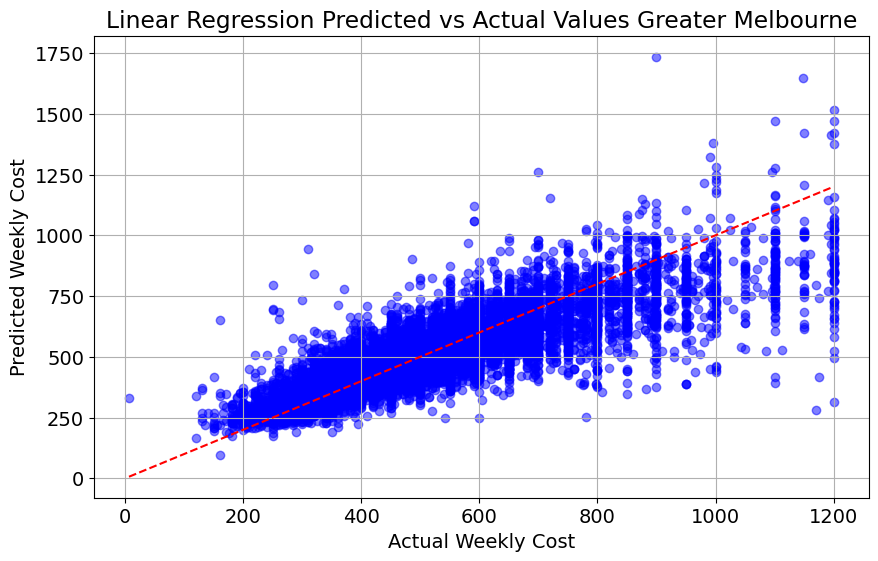

In [38]:
# PREDICTED VS ACTUAL WITH INTERACTION TERMS

plt.figure(figsize=(10, 6))
plt.scatter(y_test_gm_orig, y_pred_poly_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_gm_orig), max(y_test_gm_orig)], [min(y_test_gm_orig), max(y_test_gm_orig)], color='red', linestyle='--')
plt.title('Linear Regression Predicted vs Actual Values Greater Melbourne')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.show()


- Modelling with **Interaction** and **Feature Selection**

In [39]:
# Step 1: Add interaction terms (degree=2 for interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_gm)
X_test_poly = poly.transform(X_test_gm)

# Step 2: Perform Recursive Feature Elimination (RFE)
lr_model_rfe = LinearRegression()
rfe = RFE(lr_model_rfe, n_features_to_select=15)  # Select 15 most important features
rfe.fit(X_train_poly, y_train_gm)

# Step 3: Selected features
selected_features = poly.get_feature_names_out(X_gm.columns)[rfe.support_]
print("Selected features by RFE (with interaction terms):", selected_features)

# Step 4: Train the model using only the selected features
X_train_selected = rfe.transform(X_train_poly)
X_test_selected = rfe.transform(X_test_poly)
lr_model_rfe.fit(X_train_selected, y_train_gm)

# Step 5: Predictions and evaluation (log-transformed scale)
y_pred_rfe = lr_model_rfe.predict(X_test_selected)
mse_rfe = mean_squared_error(y_test_gm, y_pred_rfe)
print('Linear Regression MSE after RFE (log-transformed scale):', mse_rfe)

# Step 6: Back-transform the predictions and calculate MSE and RMSE on the original scale
y_pred_rfe_orig = np.expm1(y_pred_rfe)
mse_rfe_original = mean_squared_error(y_test_gm_orig, y_pred_rfe_orig)
rmse_rfe_original = np.sqrt(mse_rfe_original)

# Step 7: Output MSE and RMSE on original scale
print('Linear Regression MSE after RFE (original scale):', mse_rfe_original)
print('Linear Regression RMSE after RFE (original scale):', rmse_rfe_original)

# Step 8: Print coefficients for the selected features
importance_rfe = lr_model_rfe.coef_

print("\nFeature Importance (Coefficients) for Selected Features after RFE:")
for feature, importance in zip(selected_features, importance_rfe):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


Selected features by RFE (with interaction terms): ['beds housing_index' 'beds cpi_without_housing' 'baths housing_index'
 'baths cpi_without_housing' 'dist_to_parks_and_gardens housing_index'
 'dist_to_parks_and_gardens cpi_without_housing'
 'num_homeless_persons housing_index'
 'num_homeless_persons cpi_without_housing'
 'avg_household_size housing_index'
 'avg_household_size cpi_without_housing' 'num_businesses housing_index'
 'num_businesses cpi_without_housing' 'median_age housing_index'
 'median_age cpi_without_housing'
 'percent_rental_properties cpi_without_housing']
Linear Regression MSE after RFE (log-transformed scale): 0.11680303885263922
Linear Regression MSE after RFE (original scale): 33098.76854309159
Linear Regression RMSE after RFE (original scale): 181.93066960546147

Feature Importance (Coefficients) for Selected Features after RFE:
Feature: beds housing_index, Coefficient: -371059002080.1086
Feature: beds cpi_without_housing, Coefficient: 371059002080.1121
Feature:

##### **3. Random Forest Regression:**

Random Forest MSE (log-transformed scale): 0.017811728357880738
Random Forest MSE (original scale): 5403.677575623409
Random Forest RMSE (original scale): 73.50971075731022


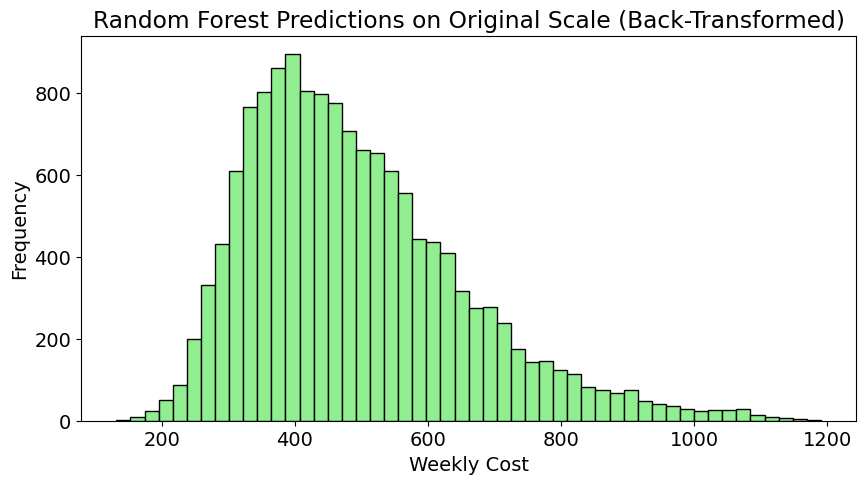


Feature Importances (Random Forest):
Feature: beds, Importance: 0.0940
Feature: baths, Importance: 0.1771
Feature: parking, Importance: 0.0125
Feature: dist_to_city, Importance: 0.0901
Feature: dist_to_education, Importance: 0.0262
Feature: dist_to_parks_and_gardens, Importance: 0.0253
Feature: dist_to_train_station, Importance: 0.0272
Feature: dist_to_healthcare, Importance: 0.0249
Feature: num_homeless_persons, Importance: 0.0092
Feature: avg_household_size, Importance: 0.0286
Feature: num_businesses, Importance: 0.0256
Feature: median_income, Importance: 0.0830
Feature: median_age, Importance: 0.0367
Feature: percent_aboriginal_torres_strait_islander, Importance: 0.0384
Feature: percent_au_citizen, Importance: 0.0123
Feature: percent_overseas_born, Importance: 0.0123
Feature: percent_rental_properties, Importance: 0.0126
Feature: population, Importance: 0.0933
Feature: percent_unemployed, Importance: 0.0222
Feature: housing_index, Importance: 0.0819
Feature: cpi_without_housing, Im

In [40]:
# Step 1: Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune n_estimators
rf_model.fit(X_train_gm, y_train_gm)

# Step 2: Make predictions on the test set (log-transformed)
y_pred_rf_gm = rf_model.predict(X_test_gm)

# Step 3: Evaluate the model on the log-transformed data (MSE in log scale)
mse_rf_log = mean_squared_error(y_test_gm, y_pred_rf_gm)
print('Random Forest MSE (log-transformed scale):', mse_rf_log)

# Step 4: Back-transform the predictions and true values to the original scale
y_pred_rf_gm_orig = np.expm1(y_pred_rf_gm)  # Convert predictions back to the original scale
y_test_gm_orig = np.expm1(y_test_gm)        # Convert true values back to the original scale

# Step 5: Calculate MSE and RMSE on the original scale
mse_rf_original = mean_squared_error(y_test_gm_orig, y_pred_rf_gm_orig)
rmse_rf_original = np.sqrt(mse_rf_original)
print('Random Forest MSE (original scale):', mse_rf_original)
print('Random Forest RMSE (original scale):', rmse_rf_original)

# Step 6: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_rf_gm_orig, bins=50, color='lightgreen', edgecolor='black')
plt.title('Random Forest Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 7: Feature Importances
importance_rf = rf_model.feature_importances_
feature_names = X_gm.columns

print("\nFeature Importances (Random Forest):")
for feature, importance in zip(feature_names, importance_rf):
    print(f'Feature: {feature}, Importance: {importance:.4f}')


- Plotting the **Random Forest Model**

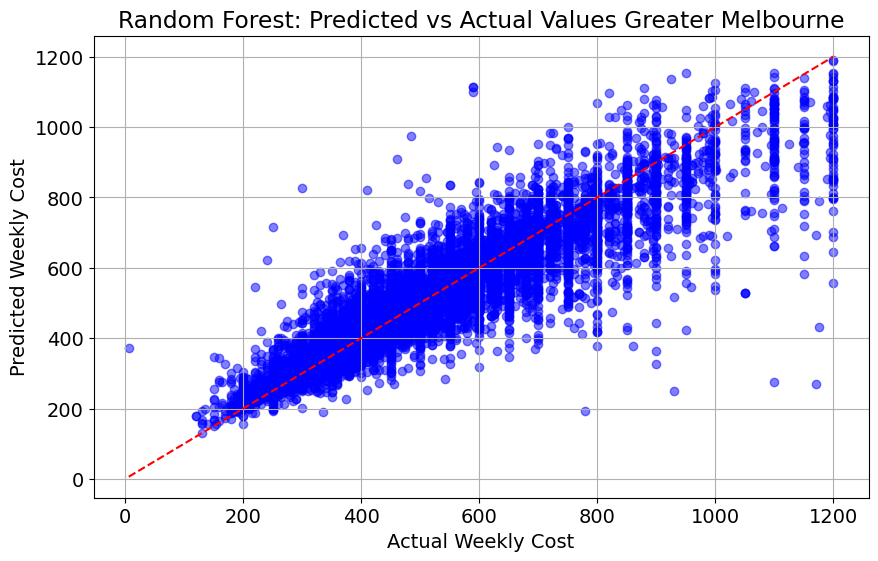

In [41]:
# PLOTTING PREDICTED VS ACTUAL 

plt.figure(figsize=(10, 6))
plt.scatter(y_test_gm_orig, y_pred_rf_gm_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_gm_orig), max(y_test_gm_orig)], [min(y_test_gm_orig), max(y_test_gm_orig)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Values Greater Melbourne')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.show()


- Plotting **Feature Importance**

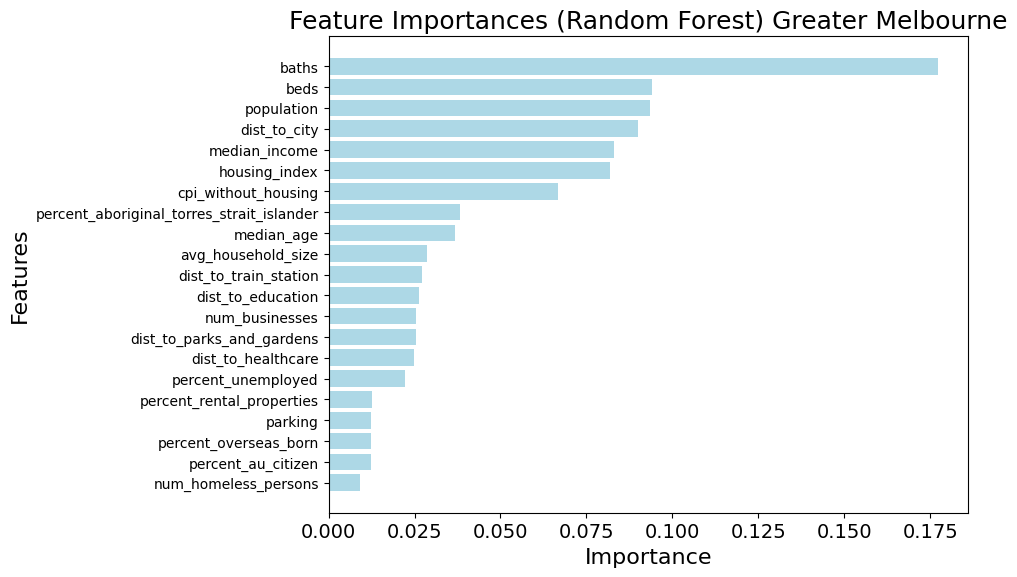

In [42]:
# Set global font size
plt.rc('font', size=14)  # Set default font size for all text elements

# Plotting feature importances as a bar chart
plt.figure(figsize=(10, 6))

# Sorting the features by importance for better visualization
sorted_idx = np.argsort(importance_rf)[::-1]
sorted_importance_rf = importance_rf[sorted_idx]
sorted_feature_names_rf = feature_names[sorted_idx]

# Create a bar chart
plt.barh(sorted_feature_names_rf, sorted_importance_rf, color='lightblue')

# Set axis labels and title with specific font sizes
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)  # Optional, as y-axis label might be redundant for barh
plt.title('Feature Importances (Random Forest) Greater Melbourne', fontsize=18)

# Customize tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)

# Invert the y-axis to display the most important features at the top
plt.gca().invert_yaxis()

# Adjust layout to avoid clipping
plt.tight_layout()

# Show plot
plt.show()


### 2. Rest-of-Vic Models

In [43]:
rest_of_vic.head()

,beds,baths,parking,dist_to_city,dist_to_education,dist_to_parks_and_gardens,dist_to_train_station,dist_to_healthcare,weekly_cost,num_homeless_persons,...,median_income,median_age,percent_aboriginal_torres_strait_islander,percent_au_citizen,percent_overseas_born,percent_rental_properties,population,percent_unemployed,housing_index,cpi_without_housing
0,4.0,2.0,2.0,91.83735,2.87569,3.17059,2.96902,4.72762,520.0,47.800000,...,52582.2,45.16,2.400000,15.400000,13.34,27.166667,14208.250639,4.633333,145.288421,127.830132
1,4.0,2.0,2.0,91.83735,2.87569,3.17059,2.96902,4.72762,570.0,47.800000,...,52582.2,45.16,2.400000,15.400000,13.34,27.166667,14208.250639,4.633333,145.288421,127.830132
2,4.0,1.0,2.0,73.33843,6.35949,11.11772,14.49050,14.74958,400.0,54.314085,...,43543.5,52.08,1.860000,10.470000,8.06,8.983333,13106.132992,2.280000,141.520263,125.573860
3,4.0,1.0,2.0,73.33843,6.35949,11.11772,14.49050,14.74958,400.0,51.902817,...,41110.9,51.04,1.700000,9.450000,7.90,8.883333,12696.762148,2.600000,133.983947,121.061316
4,2.0,1.0,3.0,22.60075,0.78947,0.44253,20.22319,18.39855,380.0,15.333333,...,65085.4,37.64,1.533333,4.326667,9.68,10.800000,14208.250639,2.373333,145.288421,127.830132


To keep consistent, we decide to remove the top 97.5% of properties as we did with the Greater Melbourne data to combat any potential outliers

In [44]:
# Handling any missing data
rest_of_vic = rest_of_vic.dropna()

# Finding the bottom 95% of data
threshold = rest_of_vic['weekly_cost'].quantile(0.975)

# Filtering out the top 5%, retaining the bottom 97.5% of properties
rest_of_vic = rest_of_vic[rest_of_vic['weekly_cost'] <= threshold]

##### **1. Regular Linear Regression:**

- Building model **With No Interaction**

Linear Regression MSE (log-transformed scale): 0.04472747079054119
Linear Regression MSE (original scale): 4546.951600526425
Linear Regression RMSE (original scale): 67.43108778987941


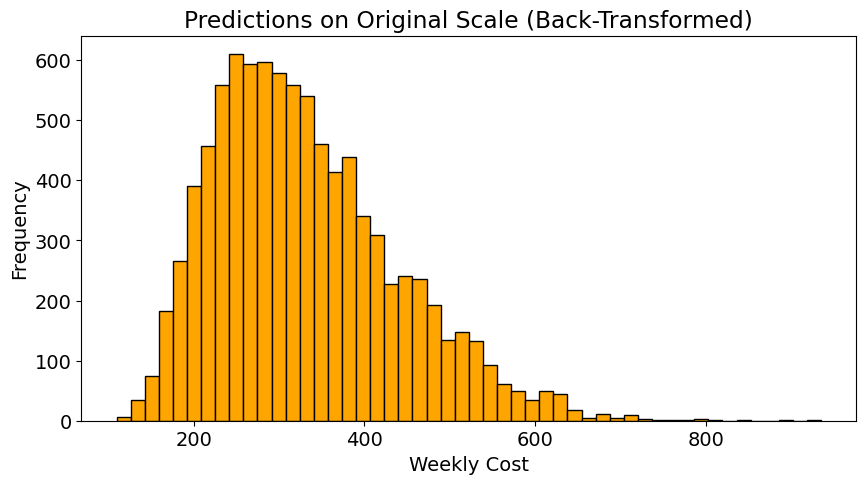


Feature Importances (Coefficients):
Feature: beds, Coefficient: 0.1267
Feature: baths, Coefficient: 0.0697
Feature: parking, Coefficient: 0.0316
Feature: dist_to_city, Coefficient: -0.0638
Feature: dist_to_education, Coefficient: 0.0132
Feature: dist_to_parks_and_gardens, Coefficient: -0.0126
Feature: dist_to_train_station, Coefficient: -0.0157
Feature: dist_to_healthcare, Coefficient: 0.0049
Feature: num_homeless_persons, Coefficient: 0.0132
Feature: avg_household_size, Coefficient: 0.0271
Feature: num_businesses, Coefficient: 0.0051
Feature: median_income, Coefficient: 0.0198
Feature: median_age, Coefficient: 0.0459
Feature: percent_aboriginal_torres_strait_islander, Coefficient: -0.0220
Feature: percent_au_citizen, Coefficient: 0.0095
Feature: percent_overseas_born, Coefficient: 0.0555
Feature: percent_rental_properties, Coefficient: 0.0382
Feature: population, Coefficient: 0.0129
Feature: percent_unemployed, Coefficient: -0.0476
Feature: housing_index, Coefficient: 469213817594.90

In [45]:
# Step 1: Drop NaN values
rest_of_vic = rest_of_vic.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_rov = rest_of_vic.drop(columns=['weekly_cost'])
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])  # log1p for better handling of small values

# Step 3: Scale the features
scaler = StandardScaler()
X_rov_scaled = scaler.fit_transform(X_rov)

# Step 4: Split the dataset into training and testing sets
X_train_rov, X_test_rov, y_train_rov, y_test_rov = train_test_split(X_rov_scaled, y_rov_log, test_size=0.2, random_state=42)

# Step 5: Train the Linear Regression model
lr_model_rov = LinearRegression()
lr_model_rov.fit(X_train_rov, y_train_rov)

# Step 6: Make predictions on the test set (log-transformed)
y_pred_lr_rov = lr_model_rov.predict(X_test_rov)

# Step 7: Evaluate the model on the log-transformed data (MSE in log scale)
mse_log_rov = mean_squared_error(y_test_rov, y_pred_lr_rov)
print('Linear Regression MSE (log-transformed scale):', mse_log_rov)

# Step 8: Back-transform the predictions and true values to the original scale
y_pred_lr_rov_orig = np.expm1(y_pred_lr_rov)  # Convert predictions back to the original scale
y_test_rov_orig = np.expm1(y_test_rov)        # Convert true values back to the original scale

# Step 9: Calculate MSE and RMSE on the original scale
mse_original_rov = mean_squared_error(y_test_rov_orig, y_pred_lr_rov_orig)
rmse_original_rov = np.sqrt(mse_original_rov)
print('Linear Regression MSE (original scale):', mse_original_rov)
print('Linear Regression RMSE (original scale):', rmse_original_rov)

# Step 11: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_lr_rov_orig, bins=50, color='orange', edgecolor='black')
plt.title('Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 12: Coefficients with feature names
importance_lr_rov = lr_model_rov.coef_
feature_names = X_rov.columns

print("\nFeature Importances (Coefficients):")
for feature, importance in zip(feature_names, importance_lr_rov):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


- Building model **With Interaction**

Linear Regression MSE (log-transformed scale): 0.03532403098664384
Linear Regression MSE (original scale): 3605.6354094987396
Linear Regression RMSE (original scale): 60.0469433818137


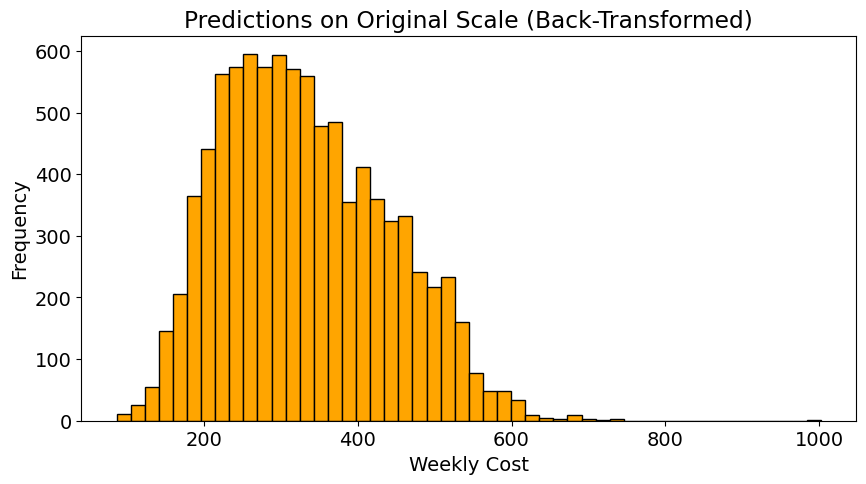


Feature Importances (Coefficients) with Interaction Terms:
Feature: beds, Coefficient: -18033447520.8407
Feature: baths, Coefficient: -329983266762.0471
Feature: parking, Coefficient: 191817199648.3185
Feature: dist_to_city, Coefficient: -94975003091.7932
Feature: dist_to_education, Coefficient: 47409234331.8797
Feature: dist_to_parks_and_gardens, Coefficient: 256949980030.9919
Feature: dist_to_train_station, Coefficient: -134753941461.5715
Feature: dist_to_healthcare, Coefficient: 40001915979.8428
Feature: num_homeless_persons, Coefficient: 7279651701.5391
Feature: avg_household_size, Coefficient: 55120392970.3728
Feature: num_businesses, Coefficient: -56088348173.0834
Feature: median_income, Coefficient: 10235256204.8734
Feature: median_age, Coefficient: -86062700580.3571
Feature: percent_aboriginal_torres_strait_islander, Coefficient: 80913509186.2388
Feature: percent_au_citizen, Coefficient: 67617363472.0497
Feature: percent_overseas_born, Coefficient: -85661115957.9211
Feature: p

In [46]:
# Step 1: Drop NaN values
rest_of_vic = rest_of_vic.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_rov = rest_of_vic.drop(columns=['weekly_cost'])
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])  # log1p for better handling of small values

# Step 3: Add interaction terms (degree=2 for interaction terms only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_rov_poly = poly.fit_transform(X_rov)

# Step 4: Scale the features
scaler = StandardScaler()
X_rov_scaled = scaler.fit_transform(X_rov_poly)

# Step 5: Split the dataset into training and testing sets
X_train_rov, X_test_rov, y_train_rov, y_test_rov = train_test_split(X_rov_scaled, y_rov_log, test_size=0.2, random_state=42)

# Step 6: Train the Linear Regression model
lr_model_rov = LinearRegression()
lr_model_rov.fit(X_train_rov, y_train_rov)

# Step 7: Make predictions on the test set (log-transformed)
y_pred_lr_rov = lr_model_rov.predict(X_test_rov)

# Step 8: Evaluate the model on the log-transformed data (MSE in log scale)
mse_log_rov = mean_squared_error(y_test_rov, y_pred_lr_rov)
print('Linear Regression MSE (log-transformed scale):', mse_log_rov)

# Step 9: Back-transform the predictions and true values to the original scale
y_pred_lr_rov_orig = np.expm1(y_pred_lr_rov)  # Convert predictions back to the original scale
y_test_rov_orig = np.expm1(y_test_rov)        # Convert true values back to the original scale

# Step 10: Calculate MSE and RMSE on the original scale
mse_original_rov = mean_squared_error(y_test_rov_orig, y_pred_lr_rov_orig)
rmse_original_rov = np.sqrt(mse_original_rov)
print('Linear Regression MSE (original scale):', mse_original_rov)
print('Linear Regression RMSE (original scale):', rmse_original_rov)

# Step 11: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10, 5))
plt.hist(y_pred_lr_rov_orig, bins=50, color='orange', edgecolor='black')
plt.title('Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 12: Coefficients with feature names
importance_lr_rov = lr_model_rov.coef_

# Get feature names from the PolynomialFeatures object
feature_names_poly = poly.get_feature_names_out(X_rov.columns)

print("\nFeature Importances (Coefficients) with Interaction Terms:")
for feature, importance in zip(feature_names_poly, importance_lr_rov):
    print(f'Feature: {feature}, Coefficient: {importance:.4f}')


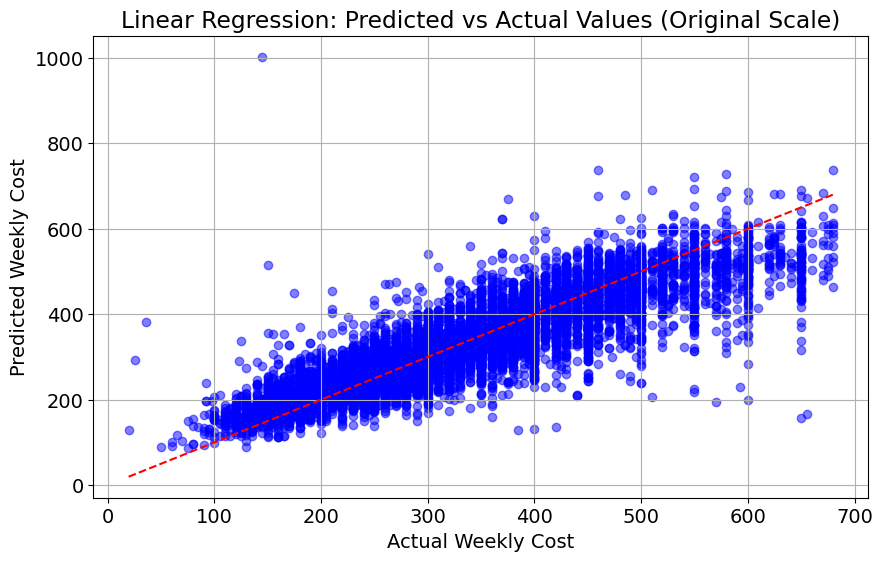

In [51]:
# PLOTTING  PREDICTED VS ACTUAL 

plt.figure(figsize=(10, 6))
plt.scatter(y_test_rov_orig, y_pred_lr_rov_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_rov_orig), max(y_test_rov_orig)], [min(y_test_rov_orig), max(y_test_rov_orig)], color='red', linestyle='--')
plt.title('Linear Regression: Predicted vs Actual Values (Original Scale)')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.savefig("../plots/rv_lr_pred_vs_actual.jpg")
plt.show()


##### **2. Random Forest Regression:**

Random Forest MSE (log-transformed scale): 0.01791780230792556
Random Forest MSE (original scale): 1922.7815130398355
Random Forest RMSE (original scale): 43.84953264334565


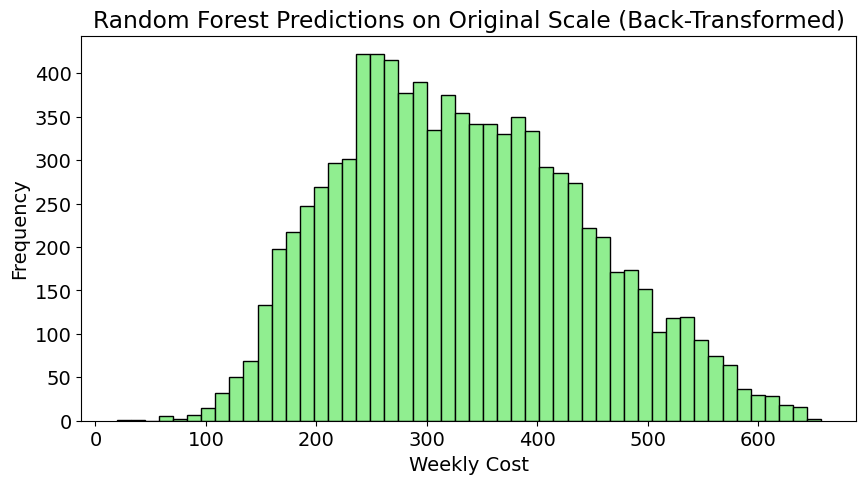


Feature Importances (Random Forest):
Feature: beds, Importance: 0.1054
Feature: baths, Importance: 0.1867
Feature: parking, Importance: 0.0117
Feature: dist_to_city, Importance: 0.0573
Feature: dist_to_education, Importance: 0.0283
Feature: dist_to_parks_and_gardens, Importance: 0.0245
Feature: dist_to_train_station, Importance: 0.0287
Feature: dist_to_healthcare, Importance: 0.0250
Feature: num_homeless_persons, Importance: 0.0117
Feature: avg_household_size, Importance: 0.0106
Feature: num_businesses, Importance: 0.0112
Feature: median_income, Importance: 0.0592
Feature: median_age, Importance: 0.0094
Feature: percent_aboriginal_torres_strait_islander, Importance: 0.0232
Feature: percent_au_citizen, Importance: 0.0098
Feature: percent_overseas_born, Importance: 0.0421
Feature: percent_rental_properties, Importance: 0.0108
Feature: population, Importance: 0.0078
Feature: percent_unemployed, Importance: 0.0219
Feature: housing_index, Importance: 0.1751
Feature: cpi_without_housing, Im

In [47]:
# Step 1: Drop NaN values
rest_of_vic = rest_of_vic.dropna()

# Step 2: Separate features (X) and target variable (y) with log transformation
X_rov = rest_of_vic.drop(columns=['weekly_cost'])
y_rov_log = np.log1p(rest_of_vic['weekly_cost'])  # log1p for better handling of small values

# Step 3: Scale the features
scaler = StandardScaler()
X_rov_scaled = scaler.fit_transform(X_rov)

# Step 4: Split the dataset into training and testing sets
X_train_rov, X_test_rov, y_train_rov, y_test_rov = train_test_split(X_rov_scaled, y_rov_log, test_size=0.2, random_state=42)


# Step 4: Train the Random Forest Regressor model
rf_model_rov = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune n_estimators
rf_model_rov.fit(X_train_rov, y_train_rov)

# Step 5: Make predictions on the test set (log-transformed)
y_pred_rf_rov = rf_model_rov.predict(X_test_rov)

# Step63: Evaluate the model on the log-transformed data (MSE in log scale)
mse_rf_log_rov = mean_squared_error(y_test_rov, y_pred_rf_rov)
print('Random Forest MSE (log-transformed scale):', mse_rf_log_rov)

# Step 7: Back-transform the predictions and true values to the original scale
y_pred_rf_rov_orig = np.expm1(y_pred_rf_rov)  # Convert predictions back to the original scale
y_test_rov_orig = np.expm1(y_test_rov)        # Convert true values back to the original scale

# Step 8: Calculate MSE and RMSE on the original scale
mse_rf_original_rov = mean_squared_error(y_test_rov_orig, y_pred_rf_rov_orig)
rmse_rf_original_rov = np.sqrt(mse_rf_original_rov)
print('Random Forest MSE (original scale):', mse_rf_original_rov)
print('Random Forest RMSE (original scale):', rmse_rf_original_rov)

# Step 9: Plot distribution of predictions on original scale (back-transformed)
plt.figure(figsize=(10,5))
plt.hist(y_pred_rf_rov_orig, bins=50, color='lightgreen', edgecolor='black')
plt.title('Random Forest Predictions on Original Scale (Back-Transformed)')
plt.xlabel('Weekly Cost')
plt.ylabel('Frequency')
plt.show()

# Step 10: Feature Importances
importance_rf_rov = rf_model_rov.feature_importances_
feature_names = X_rov.columns

print("\nFeature Importances (Random Forest):")
for feature, importance in zip(feature_names, importance_rf_rov):
    print(f'Feature: {feature}, Importance: {importance:.4f}')


- Plotting the **Random Forest Model**

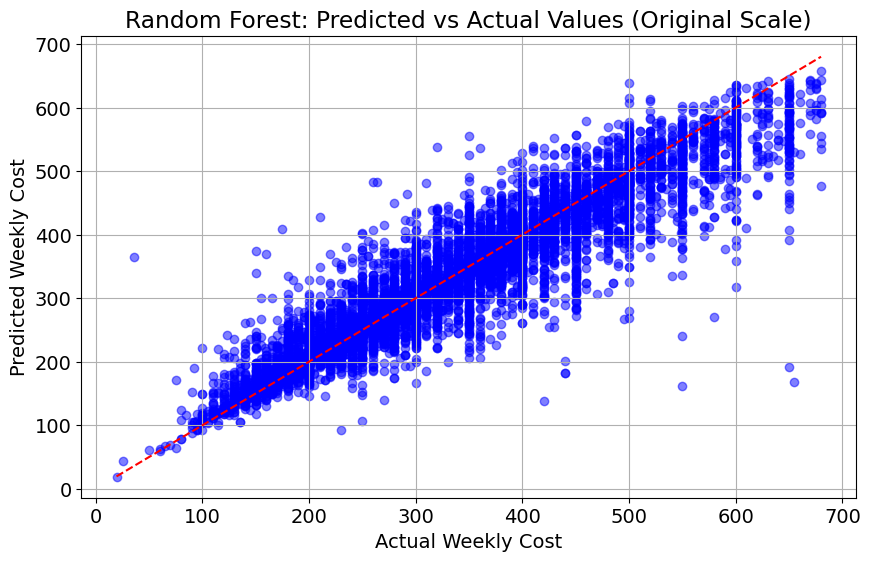

In [50]:
# PLOTTING  PREDICTED VS ACTUAL 

plt.figure(figsize=(10, 6))
plt.scatter(y_test_rov_orig, y_pred_rf_rov_orig, alpha=0.5, color='blue')
plt.plot([min(y_test_rov_orig), max(y_test_rov_orig)], [min(y_test_rov_orig), max(y_test_rov_orig)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs Actual Values (Original Scale)')
plt.xlabel('Actual Weekly Cost')
plt.ylabel('Predicted Weekly Cost')
plt.grid(True)
plt.savefig("../plots/rv_rf_pred_vs_actual.jpg")
plt.show()


- Plotting **Feature Importance**

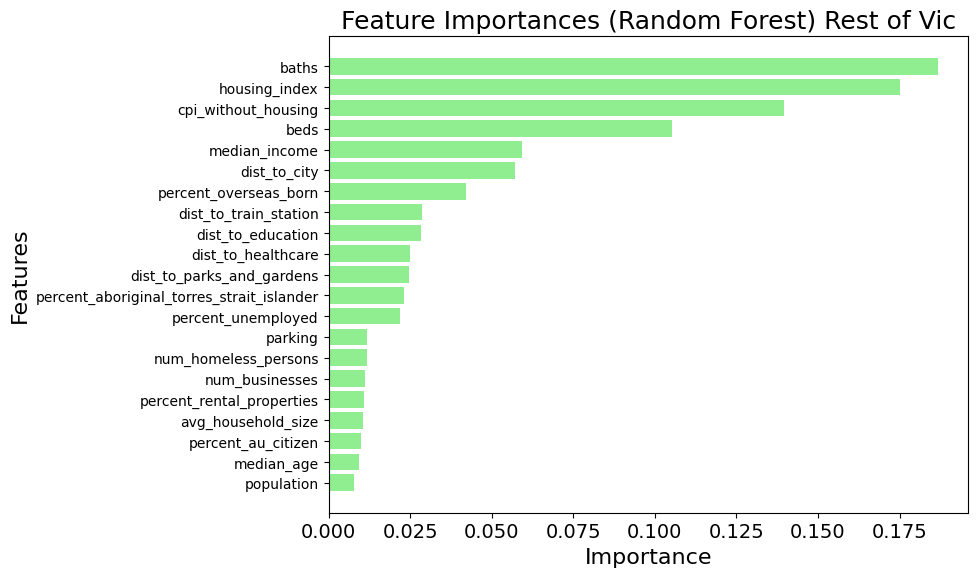

In [49]:
# Set global font size
plt.rc('font', size=14)  # Set default font size for all text

# Plotting feature importances as a bar chart
plt.figure(figsize=(10, 6))

# Sorting the features by importance for better visualization
sorted_idx_rov = np.argsort(importance_rf_rov)[::-1]
sorted_importance_rf_rov = importance_rf_rov[sorted_idx_rov]
sorted_feature_names_rf_rov = feature_names[sorted_idx_rov]

# Create a bar chart
plt.barh(sorted_feature_names_rf_rov, sorted_importance_rf_rov, color='lightgreen')

# Set axis labels and title with specific font sizes
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)  # Optional, y-axis label usually not needed for barh
plt.title('Feature Importances (Random Forest) Rest of Vic', fontsize=18)

# Customize tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)

# Invert the y-axis to display the most important features at the top
plt.gca().invert_yaxis()

# Adjust layout to avoid clipping
plt.tight_layout()

# Show plot
plt.show()
